<a href="https://colab.research.google.com/github/meng-86/Project-4/blob/main/Stroke_model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
import os
spark_version = 'spark-3.2.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()
import pandas as pd
import pyspark

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,734 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:14 http://ppa.launchpad.net/graphic

In [87]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2022-05-05 21:14:51--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar.1’

postgresql-42.2.9.j 100%[===================>] 892.61K  5.56MB/s    in 0.2s    

2022-05-05 21:14:51 (5.56 MB/s) - ‘postgresql-42.2.9.jar.1’ saved [914037/914037]



In [88]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [89]:
from pyspark import SparkFiles
url ="https://project-4.s3.eu-west-2.amazonaws.com/healthcare-dataset-stroke-data.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("healthcare-dataset-stroke-data.csv"), header=True, inferSchema=True)
df.show(10)
df = df.toPandas()
df.head()

+---+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+-----------+---------------+------+
|_c0|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|        bmi| smoking_status|stroke|
+---+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+-----------+---------------+------+
|  0| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|       36.6|formerly smoked|     1|
|  1|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|28.89323691|   never smoked|     1|
|  2|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|       32.5|   never smoked|     1|
|  3|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|       34.4|  

,_c0,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [116]:
df.info()
df= stroke_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _c0                5110 non-null   int32  
 1   id                 5110 non-null   int32  
 2   gender             5110 non-null   object 
 3   age                5110 non-null   float64
 4   hypertension       5110 non-null   int32  
 5   heart_disease      5110 non-null   int32  
 6   ever_married       5110 non-null   object 
 7   work_type          5110 non-null   object 
 8   Residence_type     5110 non-null   object 
 9   avg_glucose_level  5110 non-null   float64
 10  bmi                5110 non-null   float64
 11  smoking_status     5110 non-null   object 
 12  stroke             5110 non-null   int32  
dtypes: float64(3), int32(5), object(5)
memory usage: 419.3+ KB


In [98]:
import numpy as np
import pandas as pd

In [124]:
stroke_df = stroke_data.toPandas()
df.head()


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


### Visualisation

In [127]:
from matplotlib import pyplot as plt
import seaborn as sns

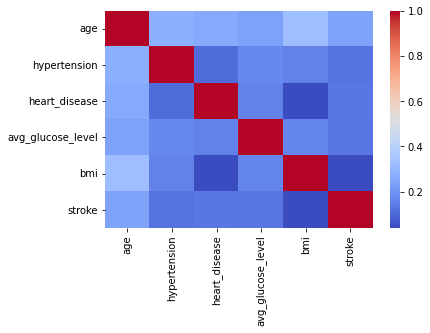

In [128]:
sns.heatmap(abs(df.corr()), cmap="coolwarm")
plt.savefig('pearsons.png', bbox_inches='tight')

## Machine learning modelling

In [129]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import ensemble
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from IPython.core.display import HTML 

### Visualisation

In [131]:
from matplotlib import pyplot as plt
import seaborn as sns

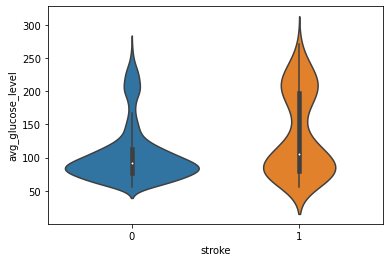

In [134]:
sns.violinplot(x=stroke_df["stroke"], y=stroke_df["avg_glucose_level"], data=stroke_df)
plt.savefig('avg_glucose_level.png', bbox_inches='tight')

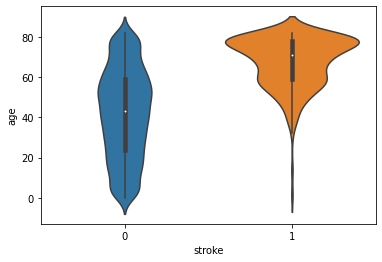

In [135]:
sns.violinplot(x=stroke_df["stroke"], y=stroke_df["age"], data=stroke_df)
plt.savefig('age.png', bbox_inches='tight')

In [137]:
df.drop(df[df["gender"] == "Other"].index, inplace=True) 
df['gender'].unique()

array(['Male', 'Female'], dtype=object)

In [138]:
print(df.isnull().sum())

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [139]:
df = df.fillna(np.mean(df['bmi']))
print(df.isnull().sum())

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [140]:
df = pd.get_dummies(df, columns=['work_type', 'smoking_status'], prefix=['work', 'smoke'])
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_Govt_job,work_Never_worked,work_Private,work_Self-employed,work_children,smoke_Unknown,smoke_formerly smoked,smoke_never smoked,smoke_smokes
0,Male,67.0,0,1,Yes,Urban,228.69,36.600000,1,0,0,1,0,0,0,1,0,0
1,Female,61.0,0,0,Yes,Rural,202.21,28.893237,1,0,0,0,1,0,0,0,1,0
2,Male,80.0,0,1,Yes,Rural,105.92,32.500000,1,0,0,1,0,0,0,0,1,0
3,Female,49.0,0,0,Yes,Urban,171.23,34.400000,1,0,0,1,0,0,0,0,0,1
4,Female,79.0,1,0,Yes,Rural,174.12,24.000000,1,0,0,0,1,0,0,0,1,0


In [141]:
df['ever_married'] = np.where(df['ever_married'] == 'Yes', 1, 0)
df['gender'] = np.where(df['gender'] == 'Male', 1, 0)
df['Residence_type'] = np.where(df['Residence_type'] == 'Urban', 1, 0)
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_Govt_job,work_Never_worked,work_Private,work_Self-employed,work_children,smoke_Unknown,smoke_formerly smoked,smoke_never smoked,smoke_smokes
0,1,67.0,0,1,1,1,228.69,36.600000,1,0,0,1,0,0,0,1,0,0
1,0,61.0,0,0,1,0,202.21,28.893237,1,0,0,0,1,0,0,0,1,0
2,1,80.0,0,1,1,0,105.92,32.500000,1,0,0,1,0,0,0,0,1,0
3,0,49.0,0,0,1,1,171.23,34.400000,1,0,0,1,0,0,0,0,0,1
4,0,79.0,1,0,1,0,174.12,24.000000,1,0,0,0,1,0,0,0,1,0


## Logistic Regression, Random Forest, ExtraTrees, and Gradient Boosting

In [143]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,VotingClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from imblearn.over_sampling import SMOTE

In [145]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(est, X_train, y_train) :
    train_sizes, train_scores, test_scores = learning_curve(estimator=est, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=5,
                                                        n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(8,10))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
    plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
    plt.grid(b='on')
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.6, 1.0])
    plt.title('%s'%est) 
    plt.show()

In [146]:
def plot_roc_curve(est,X_test,y_test) :
    probas = est.predict_proba(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,probas[:, 1])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.figure(figsize=(8,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')        
    plt.plot([0,0,1],[0,1,1],'g:')     
    plt.xlim([-0.05,1.2])
    plt.ylim([-0.05,1.2])
    plt.ylabel('Taux de vrais positifs')
    plt.xlabel('Taux de faux positifs')
    plt.show

In [147]:
X = df.drop(['stroke'],axis=1)
y = df['stroke']
sm = SMOTE(random_state=2)
X, y = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [148]:
# Logistic Regression
logit = LogisticRegression()
logit.fit(X_train, y_train)
logit.pred = logit.predict(X_test)
logit_accuracy = accuracy_score(logit.pred, y_test)
print('Accuracy:', logit_accuracy)
precision = precision_score(y_test, logit.pred)
print('Precision:', precision)
print(classification_report(y_test, logit.pred))

Accuracy: 0.9192386831275721
Precision: 0.9484083424807903
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       970
           1       0.95      0.89      0.92       974

    accuracy                           0.92      1944
   macro avg       0.92      0.92      0.92      1944
weighted avg       0.92      0.92      0.92      1944



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


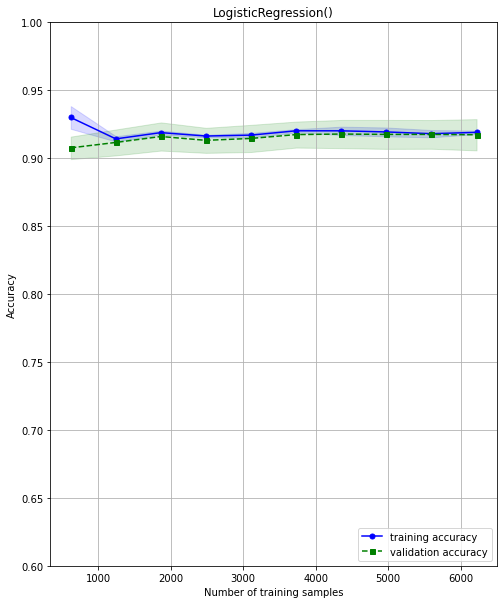

In [149]:
plot_learning_curve(logit, X_train, y_train)

In [150]:
# Random Forest
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
RF.pred = RF.predict(X_test)
RF_accuracy = accuracy_score(RF.pred, y_test)
print('Accuracy:', RF_accuracy)
precision = precision_score(y_test, RF.pred)
print('Precision:', precision)
print(classification_report(y_test, RF.pred))

Accuracy: 0.9696502057613169
Precision: 0.9800629590766002
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       970
           1       0.98      0.96      0.97       974

    accuracy                           0.97      1944
   macro avg       0.97      0.97      0.97      1944
weighted avg       0.97      0.97      0.97      1944

